In [1]:
import numpy as np
import astropy.io.fits as fits
from astropy import stats
import glob
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from numba import njit

import spiceypy as spice
import hstprojimage as hst
%matplotlib inline

OBS DATE 2014-01-06T02:35:18


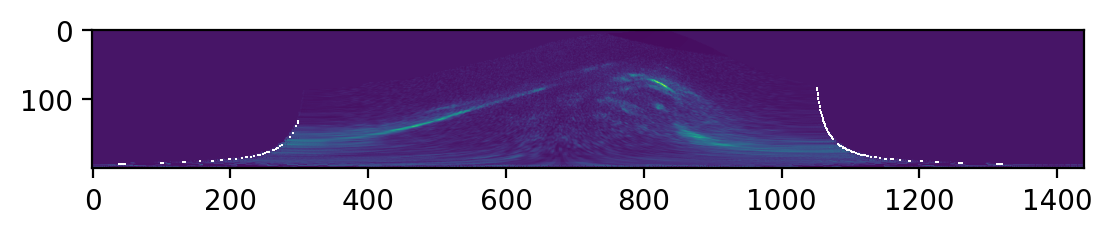

In [2]:
spice.furnsh('kernel/cassMetaK.txt')

filename = 'data/red/2014/006_v06/jup_14-006-02-35-18_0030_v06_stis_f25srf2_flatproj.fits'
ext = 0
hext = 1
with fits.open(filename) as hdul:
    image = hdul[ext].data # .astype(np.float32)
    h = hdul[hext].header

# HST data
moon = 'EUROPA'
h = hst.HSTProjImage(filename)
h.readHSTFile()
h.MOON = moon
IMG = h.image

fig, ax = plt.subplots(dpi=200)
ax.imshow(IMG)
plt.show()

R 9.332337991156118 , PHI -128.09716911462934 , SYS3 128.09716911462934
EFP LAT 52.78842080905891 , SYS3 152.62117521949583
(1000, 1000)


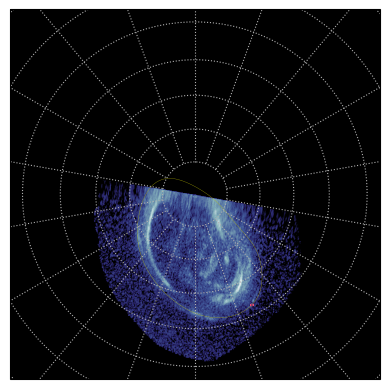

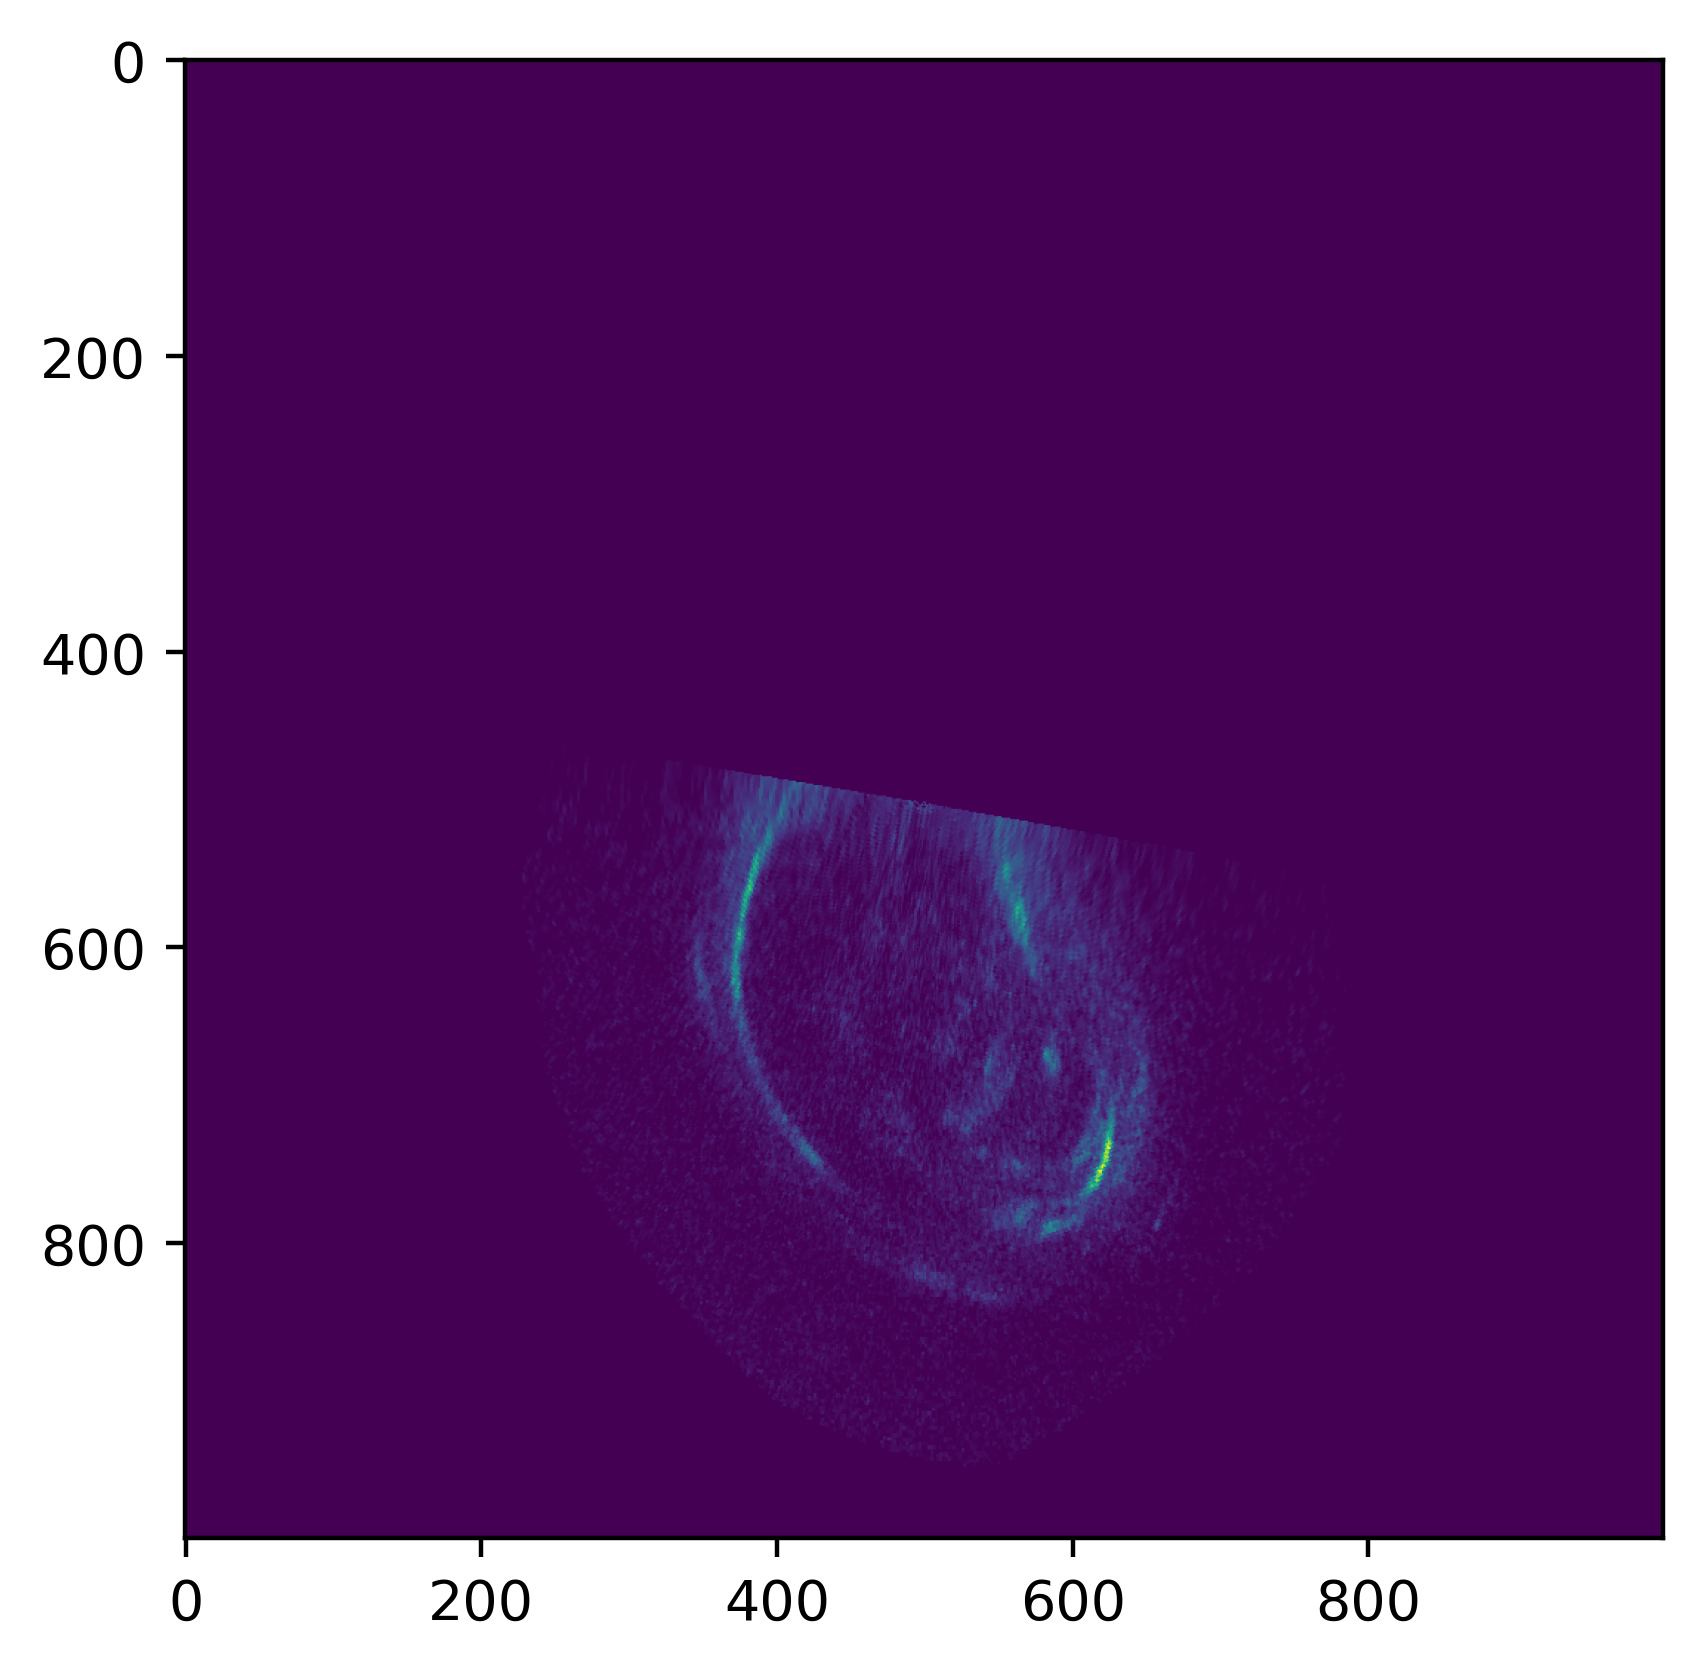

In [17]:
ax, dimage, gl = h.tvPolar(ax, vmin=10, vmax=2000,
                  draw_labels=False, refmainoval=False,
                  satovals=['eu'],
                  reflon=None,
                  # reflon=h.alm.cml,
                  )

print(dimage.shape)
dimage = dimage[::-1,::-1]
fig, ax = plt.subplots(dpi=400)
ax.imshow(dimage)
plt.show()